--- Starting Analysis on: Final.csv ---
1. Data Loading and Cleaning...
   -> Retained 14,036 high-temperature data points (feel >= 70.0°F).
2. Calculating Yearly Sensitivity Metrics...

Yearly Demand Sensitivity Summary (MW increase per 1°F increase):
|   Year |   Sensitivity_Slope |   Correlation |
|-------:|--------------------:|--------------:|
|   2020 |               4.783 |         0.059 |
|   2021 |              92.282 |         0.894 |
|   2022 |              92.614 |         0.885 |
|   2023 |              90.349 |         0.872 |
|   2024 |              85.291 |         0.892 |
|   2025 |              90.633 |         0.871 |

3. Generating Yearly Comparison Scatter Plots...


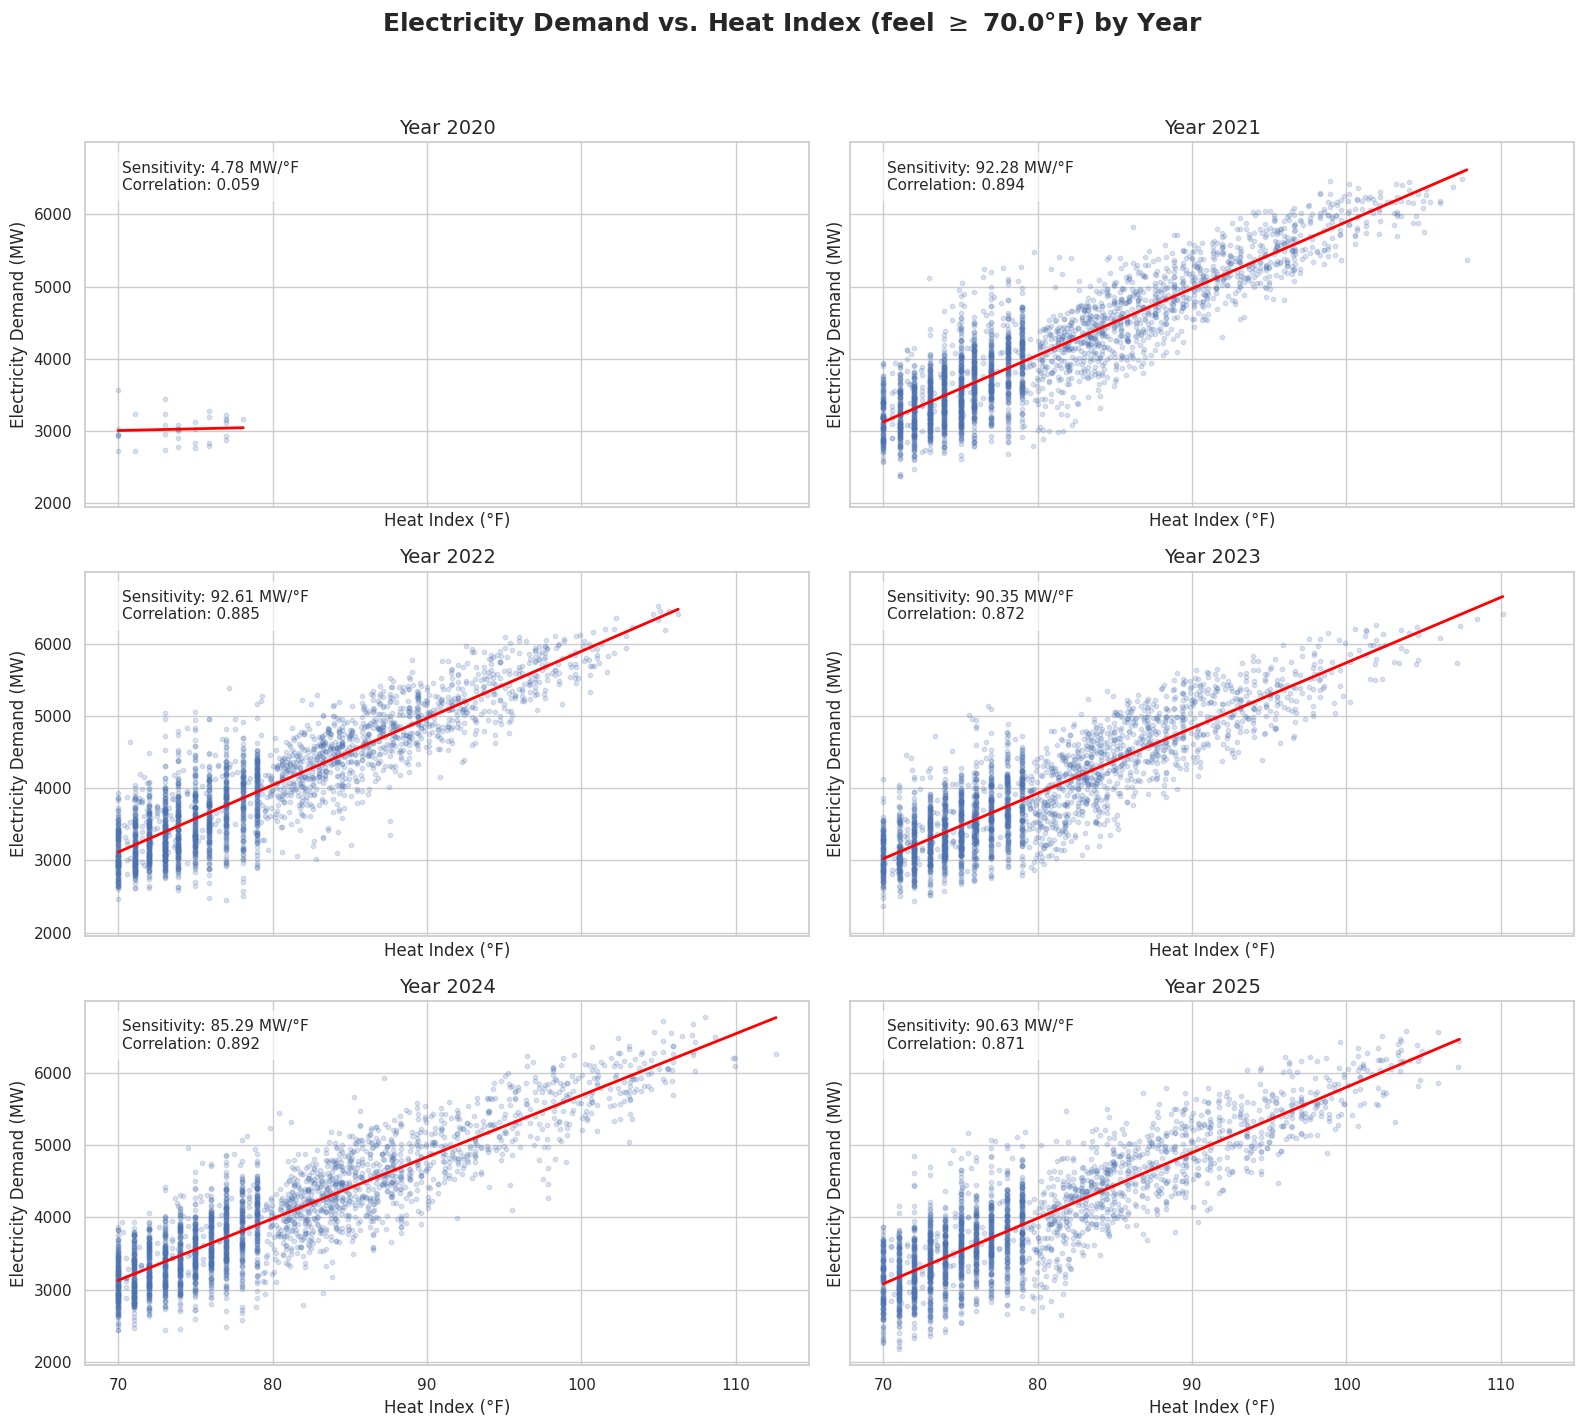

4. Generating Time Series of Sensitivity...


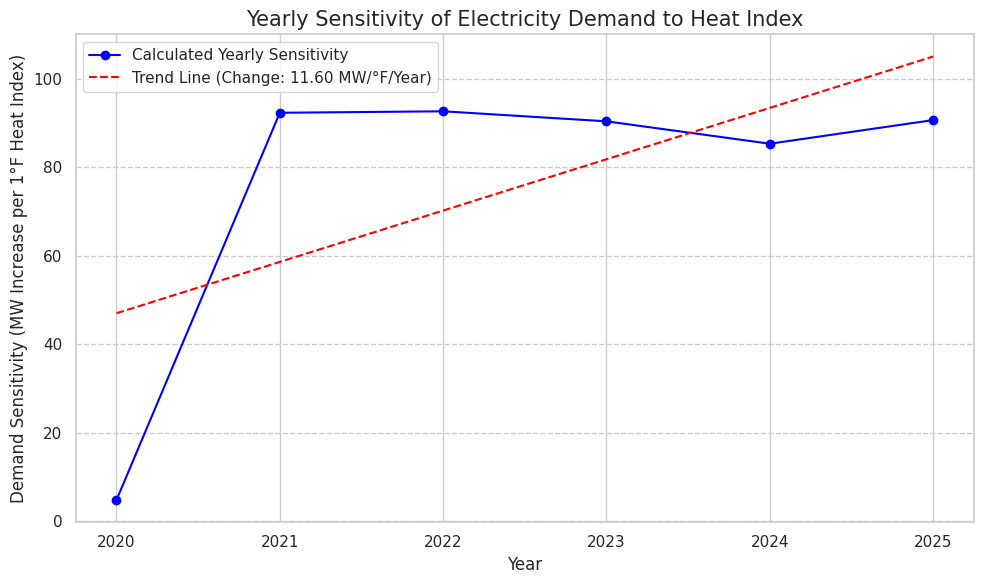


Analysis complete. Check the generated plots and the printed summary table.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import sys

COOLING_THRESHOLD_F = 70.0

def perform_demand_sensitivity_analysis(raw_data_file):
    """
    Loads merged data from the specified file, filters for high temperature hours,
    calculates yearly demand sensitivity (slope/correlation), and generates
    comparative scatter plots.

    Args:
        raw_data_file (str): The path to the CSV file containing the data.
                             It must contain 'Time_UTC', 'mw', and 'feel' columns.
    """
    print(f"--- Starting Analysis on: {raw_data_file} ---")

    try:

        df = pd.read_csv(raw_data_file, usecols=['Time_UTC', 'mw', 'feel'])
    except FileNotFoundError:
        print(f"FATAL ERROR: Could not find the raw data file '{raw_data_file}'. Please ensure the name is correct.")
        return
    except ValueError:
        print(f"FATAL ERROR: The file '{raw_data_file}' does not contain all required columns: 'Time_UTC', 'mw', and 'feel'.")
        return
    except Exception as e:
        print(f"An unexpected error occurred during file loading: {e}")
        return


    print("1. Data Loading and Cleaning...")

    df['Time_UTC'] = pd.to_datetime(df['Time_UTC'])
    df = df.set_index('Time_UTC').sort_index()


    df.dropna(subset=['mw', 'feel'], inplace=True)


    df['Year'] = df.index.year

    df_cooling = df[df['feel'] >= COOLING_THRESHOLD_F].copy()

    if df_cooling.empty:
        print(f"ERROR: No data points found above the cooling threshold of {COOLING_THRESHOLD_F}°F. Check your data or consider lowering the threshold.")
        return

    print(f"   -> Retained {len(df_cooling):,} high-temperature data points (feel >= {COOLING_THRESHOLD_F}°F).")

    yearly_results = []

    valid_years = sorted(df_cooling['Year'].unique())

    print("2. Calculating Yearly Sensitivity Metrics...")
    for year in valid_years:
        df_year = df_cooling[df_cooling['Year'] == year]

        corr, _ = pearsonr(df_year['feel'], df_year['mw'])

        slope, intercept = np.polyfit(df_year['feel'], df_year['mw'], 1)

        yearly_results.append({
            'Year': year,
            'Correlation': corr,
            'Sensitivity_Slope': slope,
            'Count': len(df_year)
        })

    df_results = pd.DataFrame(yearly_results)
    print("\nYearly Demand Sensitivity Summary (MW increase per 1°F increase):")

    print(df_results[['Year', 'Sensitivity_Slope', 'Correlation']].round(3).to_markdown(index=False))

    sns.set_theme(style="whitegrid")

    print("\n3. Generating Yearly Comparison Scatter Plots...")

    num_years = len(valid_years)
    cols = 2

    rows = int(np.ceil(num_years / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(16, 5 * rows), sharex=True, sharey=True)

    if num_years == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    plt.suptitle(f'Electricity Demand vs. Heat Index (feel $\\geq$ {COOLING_THRESHOLD_F}°F) by Year', fontsize=18, fontweight='bold')

    for i, year in enumerate(valid_years):
        if i >= len(axes): continue
        ax = axes[i]
        df_year = df_cooling[df_cooling['Year'] == year]

        sns.regplot(
            x='feel',
            y='mw',
            data=df_year,
            ax=ax,
            scatter_kws={'alpha':0.2, 's':10},
            line_kws={'color':'red', 'lw':2},
            ci=None
        )

        result = df_results[df_results['Year'] == year].iloc[0]
        slope_val = result['Sensitivity_Slope']
        corr_val = result['Correlation']

        ax.set_title(f'Year {year}', fontsize=14)
        ax.set_xlabel('Heat Index (°F)')
        ax.set_ylabel('Electricity Demand (MW)')

        ax.text(0.05, 0.95,
                f'Sensitivity: {slope_val:.2f} MW/°F\nCorrelation: {corr_val:.3f}',
                transform=ax.transAxes,
                fontsize=11,
                verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.6))

    for j in range(num_years, len(axes)):
        if j < len(axes):
            fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print("4. Generating Time Series of Sensitivity...")

    plt.figure(figsize=(10, 6))
    plt.plot(df_results['Year'], df_results['Sensitivity_Slope'], marker='o', linestyle='-', color='blue', label='Calculated Yearly Sensitivity')

    years_num = df_results['Year'].values
    slopes_val = df_results['Sensitivity_Slope'].values
    overall_slope, overall_intercept = np.polyfit(years_num, slopes_val, 1)

    plt.plot(years_num, overall_slope * years_num + overall_intercept,
             color='red', linestyle='--', label=f'Trend Line (Change: {overall_slope:.2f} MW/°F/Year)')

    plt.title('Yearly Sensitivity of Electricity Demand to Heat Index', fontsize=15)
    plt.xlabel('Year')
    plt.ylabel('Demand Sensitivity (MW Increase per 1°F Heat Index)')

    plt.xticks(years_num)
    plt.grid(axis='y', linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nAnalysis complete. Check the generated plots and the printed summary table.")

if __name__ == "__main__":

    FILE_TO_ANALYZE = "Final.csv"

    perform_demand_sensitivity_analysis(FILE_TO_ANALYZE)